In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# watch the tensorflow input pipeline video , tf

In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [57]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\manas\PlantDiseaseIdentify",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [58]:
class_names = dataset.class_names

In [59]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [60]:
len(dataset)

68

In [61]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 2 0 1 0 1 0 1 0 1 0 0 0 1 0 2 0 1]


(32, 256, 256, 3)


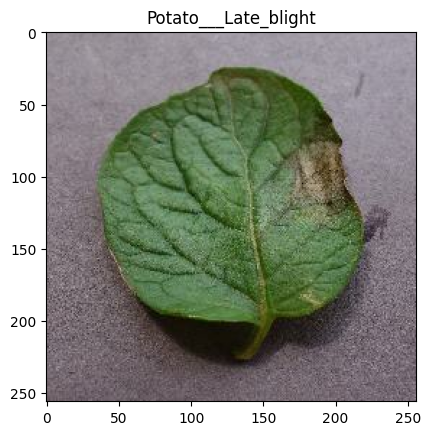

In [62]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    print(image_batch.shape)
    #print(label_batch.numpy())

### the real size or len of dataset is 68*32
### 80%==> As Training Data AND 20%==> 10%==> Validation and remaining as Test

In [63]:
Train_dataset = dataset.take(54) #len(dataset)*0.8
len(Train_dataset)

54

In [64]:
Test_and_Validate = dataset.skip(54)
len(Test_and_Validate)

14

In [65]:
Validation_size = 0.1
Test_size = 0.1
Val_Data = Test_and_Validate.take(6)#len(dataset)*Validation_size
print(len(Val_Data))

6


In [66]:
Test_Data = Test_and_Validate.skip(6)
len(Test_Data)

8

#### Or create a function to do all the partitioning

In [67]:
def get_dataset_partitioning(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)# equivalent to random_state=seed
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [68]:
Train_dataset,Val_Data,Test_Data = get_dataset_partitioning(dataset)

In [69]:
len(Train_dataset)

54

In [95]:
len(Test_Data)

8

In [70]:
Train_dataset = Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_Data = Val_Data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_Data = Test_Data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [72]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontol_and_vertical"),
    layers.RandomRotation(0.2)
])

In [73]:
input_sh = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_class = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_sh),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64 , activation='relu'),
    layers.Dense(n_class, activation = 'softmax')
])

model.build(input_shape = input_sh)

In [74]:
model2 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),  # Added Batch Normalization
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),  # Added Dropout to prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])
model2.build(input_shape = input_sh)

In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [76]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [77]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',  # Updated file extension to .keras
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


In [78]:
model2.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
model2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (32, 254, 254, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (32, 125, 125, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (32, 60, 60, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (32, 28, 28, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (32, 12, 12, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (32, 4, 4, 64)              │             2

 Total params: 185,155 (723.26 KB)

 Trainable params: 184,451 (720.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [80]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.compile(
    optimizer = 'Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [82]:
model2.compile(
    optimizer = 'Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [83]:
history = model.fit(
    Train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = Val_Data
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4544 - loss: 0.9397 - val_accuracy: 0.4792 - val_loss: 0.8258
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 990ms/step - accuracy: 0.5232 - loss: 0.8127 - val_accuracy: 0.7448 - val_loss: 0.5651
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 980ms/step - accuracy: 0.7399 - loss: 0.5969 - val_accuracy: 0.7240 - val_loss: 0.6579
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 989ms/step - accuracy: 0.7650 - loss: 0.5368 - val_accuracy: 0.8958 - val_loss: 0.3070
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 972ms/step - accuracy: 0.8425 - loss: 0.3909 - val_accuracy: 0.7865 - val_loss: 0.4901
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 973ms/step - accuracy: 0.8742 - loss: 0.3219 - val_accuracy: 0.8854 - val_loss: 0.2687
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 976ms/step - accuracy: 0.9219 - loss: 0.2368 - val_accuracy: 0.9688 - val_loss: 0.1430
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9345 - loss: 0.2011 - val_accuracy: 

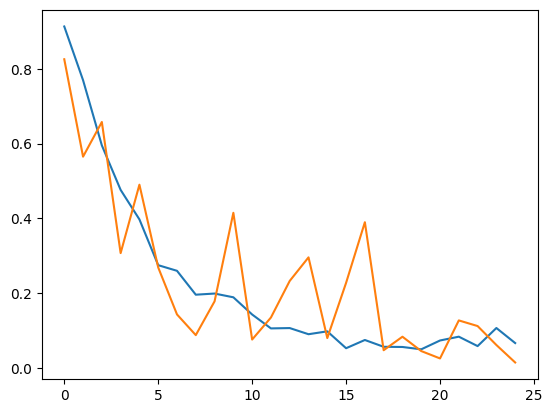

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

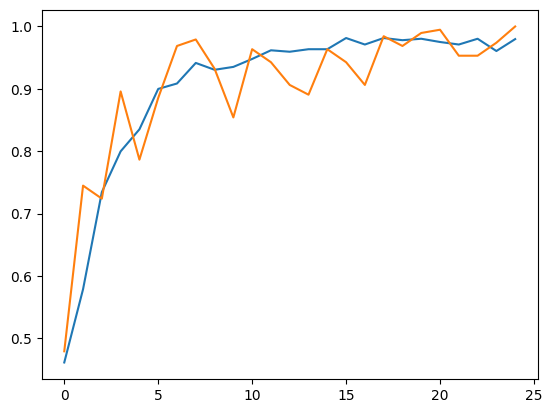

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [86]:
scores = model.evaluate(Test_Data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.9967 - loss: 0.0168


In [87]:
scores

[0.023136209696531296, 0.9921875]

In [88]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [89]:
history.history['accuracy']

[0.46122685074806213,
 0.5787037014961243,
 0.734375,
 0.7997685074806213,
 0.8350694179534912,
 0.8998842835426331,
 0.9085648059844971,
 0.9415509104728699,
 0.9305555820465088,
 0.9351851940155029,
 0.9479166865348816,
 0.9618055820465088,
 0.9594907164573669,
 0.9635416865348816,
 0.9635416865348816,
 0.9814814925193787,
 0.9710648059844971,
 0.9814814925193787,
 0.9780092835426331,
 0.9803240895271301,
 0.9751157164573669,
 0.9710648059844971,
 0.9803240895271301,
 0.9606481194496155,
 0.9797453880310059]

In [90]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

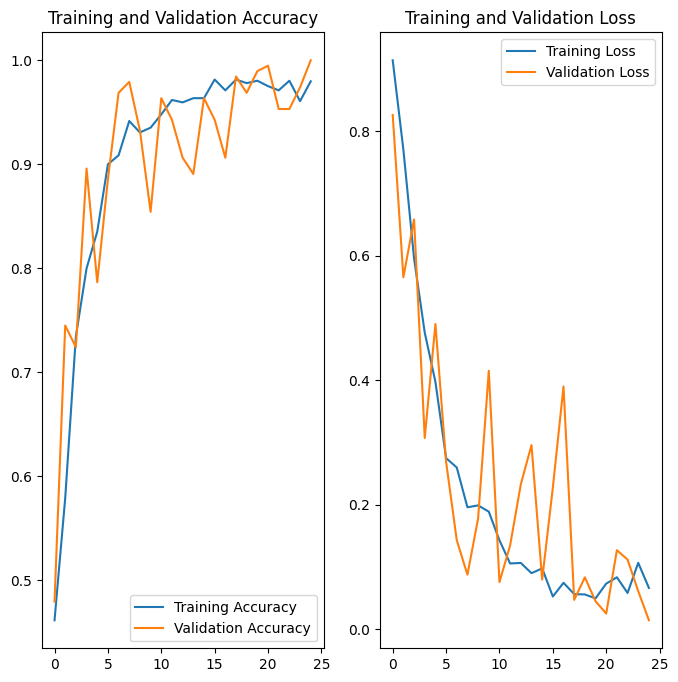

In [92]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First Image to predict: 
First Image actual Label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Predicted label:  Potato___Late_blight


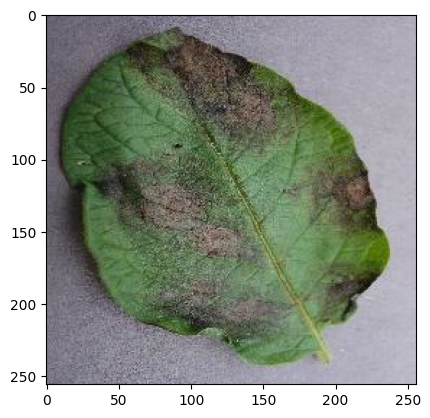

In [104]:
for images_batch, labels_batch in Test_Data.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First Image to predict: ')
    plt.imshow(first_image)
    print('First Image actual Label: ',class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])

In [114]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


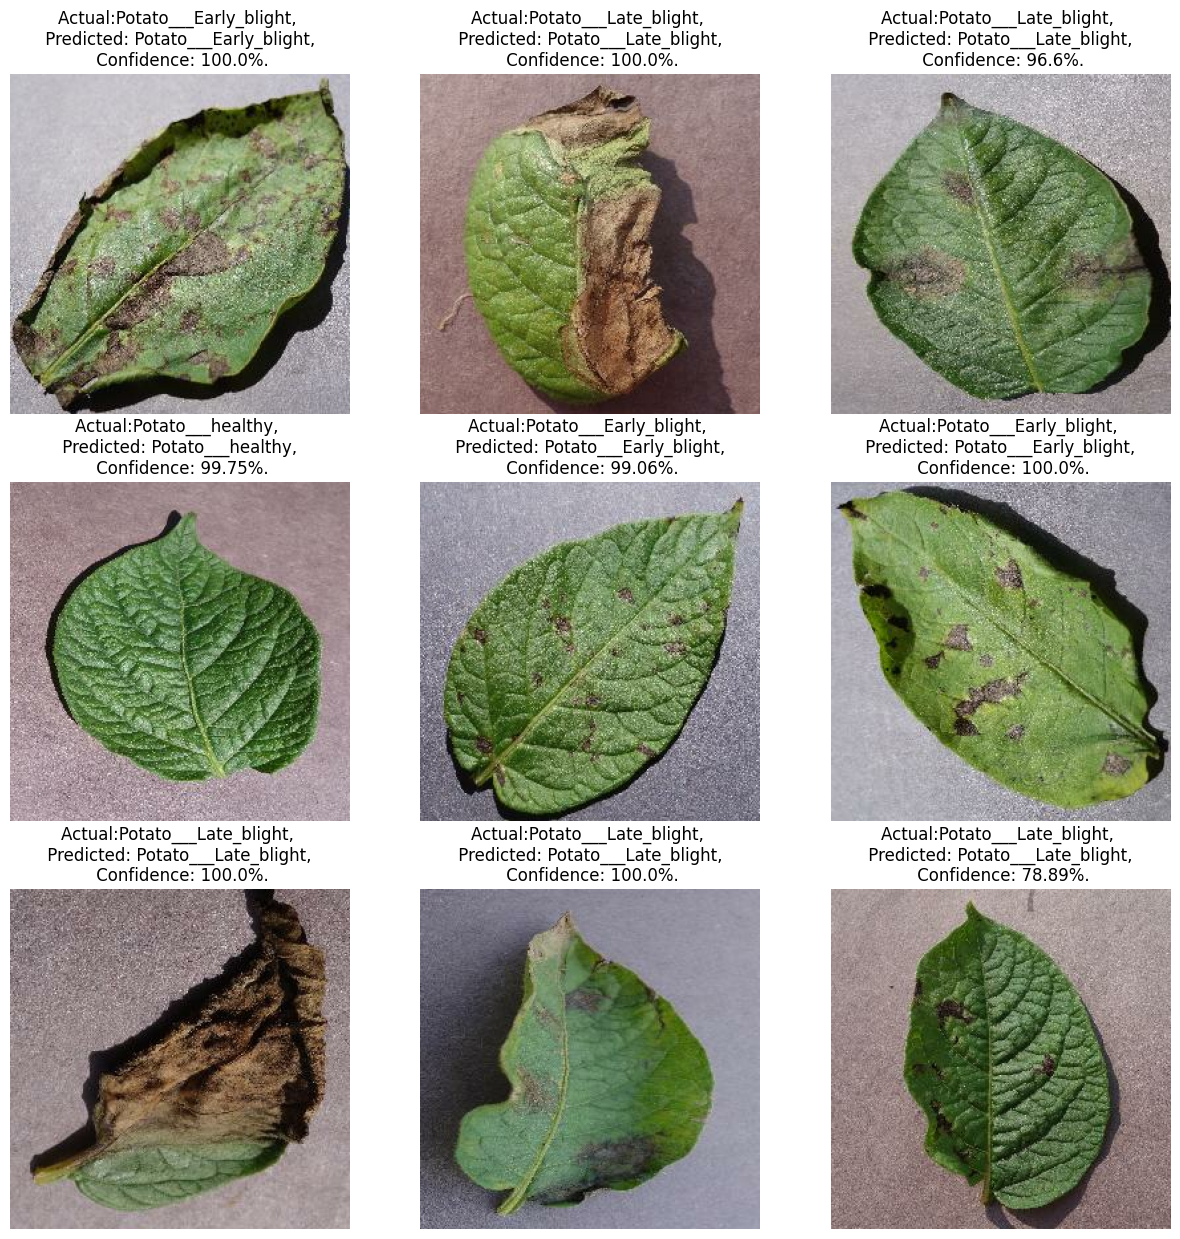

In [117]:


plt.figure(figsize=(15, 15))
for images_batch, labels_batch in Test_Data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Convert the image tensor to a numpy array
        image = images_batch[i].numpy().astype("uint8")
        
        # Display the image
        plt.imshow(image)

        predicted_class,confidence = predict(model, images_batch[i].numpy())
        actual_class = class_names[labels_batch[i]]
        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%.")
        
        # Turn off axis
        plt.axis('off')  # Corrected from plt.axes('off') to plt.axis('off')


In [147]:
model_version = 1
model.save(rf"C:\Users\manas\PlantDiseaseIdentify\models_potato\{model_version}.keras")


In [148]:
model_version2 = 2
model.save(rf"C:\Users\manas\PlantDiseaseIdentify\models_potato\{model_version2}.keras")


In [152]:
import os



In [144]:
directory_path = r"C:\Users\manas\PlantDiseaseIdentify\models_potato"

# List all files and directories in the specified path
contents = os.listdir(directory_path)

In [154]:
directory_path = r"C:\Users\manas\PlantDiseaseIdentify\models_potato"

# Extract version numbers from filenames
versions = [
    int(f.split('.')[0])
    for f in os.listdir(directory_path)
    if f.endswith('.keras') and f.split('.')[0].isdigit()
]

# If no versions are found, start with version 1
model_version = max(versions + [0]) + 1

print(f"Next model version: {model_version}")

Next model version: 3


In [145]:
contents

['model_v1.keras', 'model_v2.keras']